In [2]:
#### TASK 1 EDA and Business Insights

import pandas as pd

# Load datasets
customers = pd.read_csv('Customers 1.csv')
products = pd.read_csv('Products 1.csv')
transactions = pd.read_csv('Transactions 1.csv')

# Display basic info
print(customers.info())
print(products.info())
print(transactions.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerID    200 non-null    object
 1   CustomerName  200 non-null    object
 2   Region        200 non-null    object
 3   SignupDate    200 non-null    object
dtypes: object(4)
memory usage: 6.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ProductID    100 non-null    object 
 1   ProductName  100 non-null    object 
 2   Category     100 non-null    object 
 3   Price        100 non-null    float64
dtypes: float64(1), object(3)
memory usage: 3.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------

In [35]:
# customers.head()

In [36]:
#products.head()

In [37]:
#transactions.head()

In [38]:
#print(customers.isnull().sum())
#print(products.isnull().sum())
#print(transactions.isnull().sum())


In [11]:
#transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])
#customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])


In [39]:
#import seaborn as sns
#import matplotlib.pyplot as plt

#region_counts = customers['Region'].value_counts()
#sns.barplot(x=region_counts.index, y=region_counts.values)
#plt.title('Customers by Region')
#plt.show()

In [40]:
#top_products = transactions.groupby('ProductID')['Quantity'].sum().sort_values(ascending=False)
#print(top_products.head())


In [41]:
#merged_data = pd.merge(transactions, products, on='ProductID')
#category_revenue = merged_data.groupby('Category')['TotalValue'].sum()
#print(category_revenue)


In [42]:
#transactions.groupby(transactions['TransactionDate'].dt.month)['TotalValue'].sum().plot()
#plt.title('Monthly Revenue Trend')
#plt.show()


In [16]:
###TASK 2 - LOOKALIKE MODEL

In [17]:
#AGGREGATE CUSTOMER DATA

customer_summary = transactions.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum'
}).reset_index()


In [18]:
#NORMALIZE DATA

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
customer_summary[['TotalValue', 'Quantity']] = scaler.fit_transform(customer_summary[['TotalValue', 'Quantity']])


In [19]:
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(n_neighbors=4, metric='cosine')  # Include the customer itself
knn.fit(customer_summary[['TotalValue', 'Quantity']])
distances, indices = knn.kneighbors(customer_summary[['TotalValue', 'Quantity']])


In [20]:
lookalikes = {}
for i, customer_id in enumerate(customer_summary['CustomerID'][:20]):
    similar_customers = [(customer_summary['CustomerID'][indices[i][j]], distances[i][j]) for j in range(1, 4)]
    lookalikes[customer_id] = similar_customers

print(lookalikes)


{'C0001': [('C0057', 3.944523535581723e-07), ('C0143', 5.744243114502723e-07), ('C0120', 1.3500500171126362e-06)], 'C0002': [('C0157', 5.274149680656315e-06), ('C0003', 7.138534665274143e-05), ('C0176', 0.00010386329957123852)], 'C0003': [('C0176', 3.035912783277972e-06), ('C0030', 1.2292771276456449e-05), ('C0157', 3.785280219281706e-05)], 'C0004': [('C0106', 4.834338225956358e-06), ('C0199', 1.2549669865857815e-05), ('C0098', 1.829692790877857e-05)], 'C0005': [('C0137', 1.0216807200258415e-07), ('C0104', 2.6772525263396574e-07), ('C0092', 4.834096557493339e-07)], 'C0006': [('C0100', 2.5311125266824774e-06), ('C0079', 4.120562365650393e-06), ('C0051', 4.875237475499006e-06)], 'C0007': [('C0146', 1.6336120967075374e-06), ('C0015', 2.476769899617537e-06), ('C0117', 3.6646287600028415e-06)], 'C0008': [('C0147', 7.829241699397471e-10), ('C0073', 1.0155154396285226e-06), ('C0071', 1.17720212478023e-06)], 'C0009': [('C0141', 6.395137741588286e-08), ('C0061', 1.2214053733194952e-05), ('C0089

In [21]:
import csv

with open('Lookalike.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['CustomerID', 'LookalikeCustomers'])
    for key, value in lookalikes.items():
        writer.writerow([key, value])


In [22]:
### TASK 3 - CUSTOMER SEGMENTATION

In [34]:
customer_data = pd.merge(customers, customer_summary, on='CustomerID')

In [30]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

In [32]:
#RUN KMEANS CLUSTRING

from sklearn.cluster import MiniBatchKMeans

kmeans = MiniBatchKMeans(n_clusters=4, random_state=42, n_init=10)
customer_data['Cluster'] = kmeans.fit_predict(customer_data[['TotalValue', 'Quantity']])




C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


In [33]:
import warnings
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak")


In [25]:
#CALCULATE DB INDEX

from sklearn.metrics import davies_bouldin_score

db_index = davies_bouldin_score(customer_data[['TotalValue', 'Quantity']], customer_data['Cluster'])
print(f'DB Index: {db_index}')


DB Index: 0.725543863431002


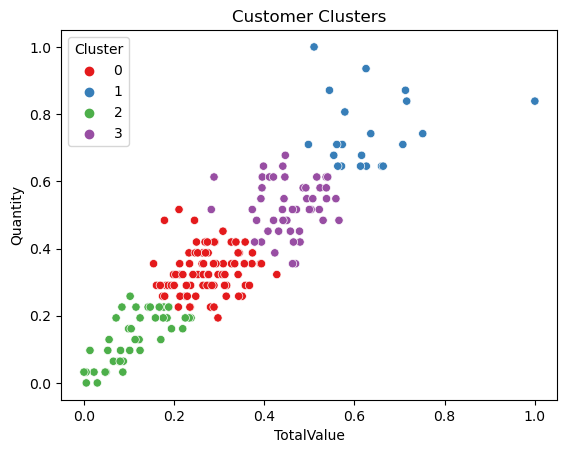

In [26]:
#VISUALIZE CLUSTERS

sns.scatterplot(x='TotalValue', y='Quantity', hue='Cluster', data=customer_data, palette='Set1')
plt.title('Customer Clusters')
plt.show()
